# Informe: Predicción de éxitos en oportunidades comerciales

## 1. Exploración de datos

En esta sección detallaremos los puntos más destacados del **análisis exploratorio** realizado sobre el conjunto de datos de entrenamiento antes de decidir sobre modelos de aprendizaje automático.

El conjunto de datos consiste en una serie de registros que detallan cierta información sobre negociaciones con diversos clientes (que llamaremos *oportunidades*). Para cada registro, se dispone de unas 50 columnas, que a grandes rasgos se dividen en:

* **Información geográfica de la oportunidad** (como "*Region*, *Territory*, *Billing Country*).
* **Información de índole burocrático** (las columnas que involucran a *Bureaucratic_Code_0* y *Delivery_Terms*).
* **Rasgos específicos del producto** (*Brand*, *Size*, *Product_Type* entre varios otros).
* **Montos involucrados en la negocación** (principalmente, *ASP*, *ASP_(converted)*, *Total_Amount* y *Total_Taxable_Amount*).
* **Indicaciones temporales** (tales como *Opportunity_Created_Date*, *Planned_Delivery_Start_Date*, *Planned_Delivery_End_Date*).
* **Detalles sobre los operadores de la empresa y los clientes** (aquí entran *Account_Name*, *Account_Owner* y *Opportunity_Owner* por ejemplo).
* **Información que identifica internamente la negociación u oportunidad**, que como explicaremos en más detalle en la Sección 2, no pueden ser utilizados para predecir el éxito o el fracaso de la oportunidad porque conducirían a un **target leakage**, es decir, la utilización de datos que no están disponibles para predecir en nuevas instancias del problema cuya resolución todavía no conocemos. En esta categoría están *Opportunity_ID* y *Sales_Contract_No*.

En primer lugar, filtraremos los datos para analizar solo aquellas oportunidades que terminaron en fracaso o éxito (es decir, su estado o "Stage" es "Closed Lost" o Closed Won").



### 1.1 Presencia de contrato

Encontramos que de toda la información provista por las columnas en el conjunto de datos, el hecho más determinante para predecir el éxito de la oportunidad es la existencia (o no) de un **contrato** para ella. Notemos que para esto no utilizamos el número de contrato en sí que figura en *Sales_Contract_No*, si no que preguntamos simplemente si este número es distinto de "None".

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

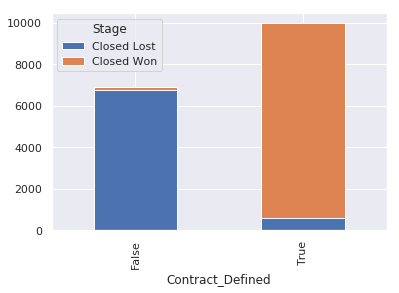

In [36]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")
data = data[(data.Stage == "Closed Won") | (data.Stage == "Closed Lost")]
data["Contract_Defined"] = data.Sales_Contract_No != "None"
pd.crosstab(data.Contract_Defined, data.Stage).plot(kind='bar', stacked=True)


In [21]:
pd.crosstab(data.Contract_Defined, data.Stage, normalize = 'index')

Stage,Closed Lost,Closed Won
Contract_Defined,,
False,0.980026,0.019974
True,0.058051,0.941949


Como se puede apreciar, en presencia de un contrato cerrado la probabilidad de cerrar la negociación es 0.94. Asimismo, la enorme mayoría de las oportunidades sin contrato definido terminan en fracaso (el 98%).

### 1.2 Temporalidad 

Las columnas con **indicaciones temporales** concentran información relevante y valiosa para predecir el éxito de una determinada oportunidad pero que no es en general utilizable en forma directa. Veamos un ejemplo de a qué nos referimos con esta última afirmación.

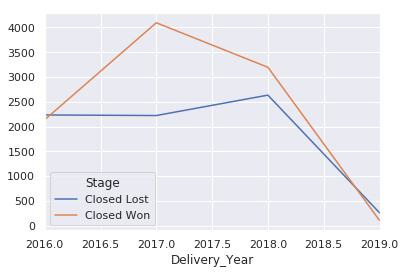

In [42]:
ct = pd.crosstab(data.Delivery_Year, data.Stage).plot(kind = 'line')

Lo que vemos en el gráfico son tasas de éxito distintas según el año en que se produjo la oportunidad (y además, parecería no haber suficiente información para decidir que 2019 fue un año no tan positivo para las ventas).  Tampoco se detecta una tendencia clara en las tasas de éxito (por ejemplo, no vemos una tasa creciente o decreciente de éxitos con el correr de los años). Dado que el objetivo es predecir el éxito de oportunidades futuras, no nos sirve que el modelo aprenda que en 2017 hubo proporcionalmente más éxitos que en otros años, con lo cual, al momento de armar los modelos de predicción decidimos descartar las columnas con fechas. Uno de los grandes desafíos de este problema consistió en _extraer observaciones importantes sobre las fechas_ del conjunto de datos sin que estas observaciones sean la fecha en sí, antes de descartarlas.

En este sentido, la idea principal consistió en **obtener información relativa a partir de las fechas**, es decir, calcular la diferencia de las fechas (medidas en días por ejemplo) entre los diversos sucesos registrados para una misma oportunidad. Un ejemplo saliente es la **cantidad de días en el rango pautado para la entrega del producto**.

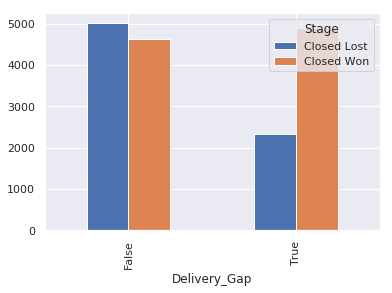

In [52]:
data["Planned_Delivery_Start_Date"] = pd.to_datetime(data.Planned_Delivery_Start_Date)
data["Planned_Delivery_End_Date"] = pd.to_datetime(data.Planned_Delivery_End_Date)
data["Delivery_Gap"] = (data.Planned_Delivery_End_Date - data.Planned_Delivery_Start_Date).dt.days == 0
pd.crosstab(data.Delivery_Gap, data.Stage).plot(kind='bar')

En la columna izquierda del gráfico se muestra la distribución de éxitos de las oportunidades en las cuales la entrega planificada no se concreta en el mismo día, mientras que del lado derecha tenemos la tasa de éxitos para aquellas en que la entrega se pauta para un determinado día. Se puede ver que la certeza en el tiempo de entrega es un factor bastante determinante para decidir el éxito o el fracaso de la negocación.

Otro rasgo que notamos que es relevante y se enmarca en las observaciones relativas obtenidas a partir de las fechas es el **tiempo que dura el contacto comercial**. Para ejemplificarlo, tomamos la diferencia entre la fecha límite prevista para la entrega y la fecha en que se creó la oportunidad comercial.

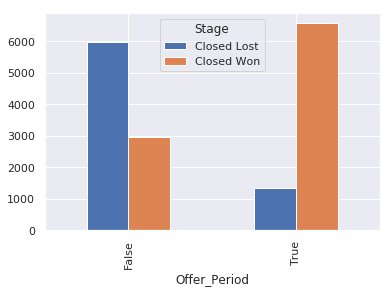

In [9]:
data["Opportunity_Created_Date"] = pd.to_datetime(data.Opportunity_Created_Date)
data["Offer_Period"] = data["Concrete_Offer"] = (data.Planned_Delivery_End_Date - data.Opportunity_Created_Date).dt.days
pd.crosstab(data.Offer_Period <= 60, data.Stage).plot(kind='bar')

En este gráfico mostramos la tasa de éxito de las oportunidades según si el contacto fue de menos o más de 60 días. Se observa que las negociaciones que se resolvieron en a lo sumo dos meses fueron generalmente mucho más exitosas que aquellas que se extendieron más allá de ese período.

### 1.3. Registros relacionados

Otra de las dificultades inherentes que encontramos en este conjunto de datos radica en que **varias oportunidades constan de más de un registro**. Una manera simple pero que resultó efectiva de extraer información significativa a partir de todos los registros correspondientes a una única oportunidad fue contarlos, es decir, relevar la cantidad de contactos comerciales que se realizan con un cliente en el marco de una oportunidad. Intuitivamente, si se producen varios contactos con un cliente hay un interés de ambas partes y esto podría favorecer el cierre exitoso de la negociación. Verifiquemos esta intuición en el conjunto de datos.

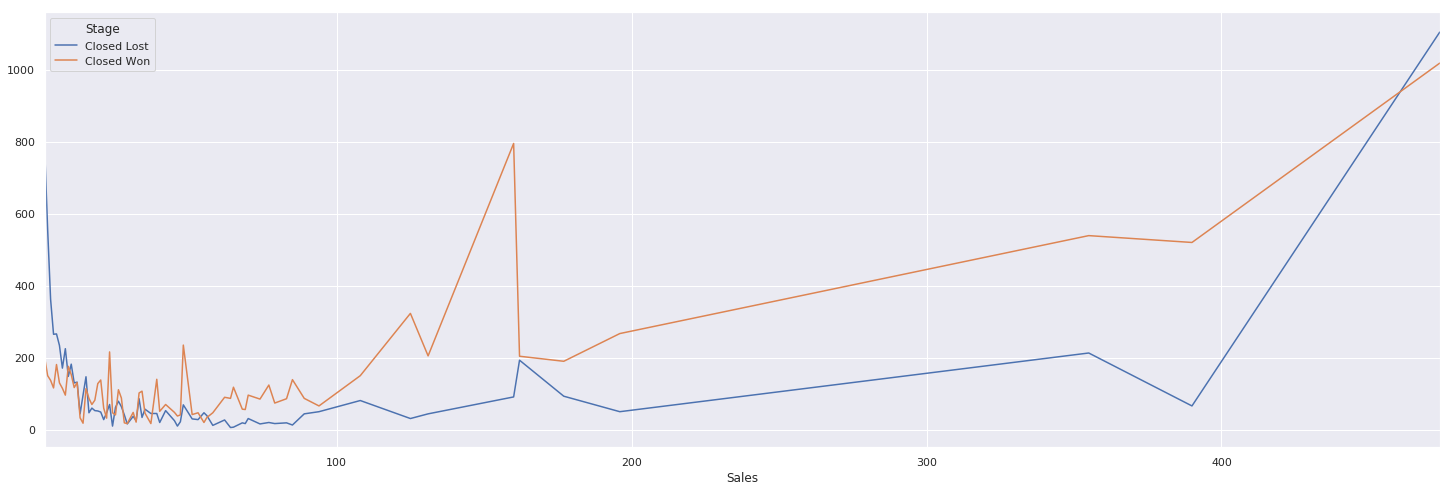

In [47]:
data["Sales"] = data.groupby("Account_Name", sort=False)["Opportunity_ID"].transform(lambda x: x.nunique())
pd.crosstab(data.Sales, data.Stage).plot(kind='line', figsize=(25, 8))

Tal como habíamos intuido, salvo algunas excepciones la tasa de éxito en las oportunidades mejora con la cantidad de contactos comerciales realizados.

## 2. Variables de entrenamiento y Feature engineering

En esta sección detallaremos las variables que utilizamos para entrenar nuestro modelos, ofreciendo una breve descripción de los **nuevos features** que generamos a partir de las columnas originales (algunos de los cuales ya se detallaron en la sección anterior).

### 2.1 Variables no utilizadas y target leakage

Empecemos por listar las variables originales que no empleamos (si bien algunas de ellas dieron origen a nuevas variables que sí fueron utilizadas):

* *ID* y *Opportunity_ID*, que identifican a la oportunidad.
* Las variables que corresponden a fechas, por el motivo que explicamos en la sección anterior. Sin embargo, a partir de algunas de ellas definimos features nuevos que especificaremos más abajo.
* La variable *Sales_Contract_No*, pues también se puede utilizar para identificar una oportunidad. Como ya explicamos, a partir de ella se obtiene una variable muy determinante que indica si estaba definido o no un número de contrato para la oportunidad en cuestión.
* Tras analizar la importancia de cada variable para los modelos que mejor rendimiento obtuvieron, decidimos prescindir de las siguientes variables: *Opportunity_Name*, *Product_Type*, *Account_Type*, *ASP_converted_Currency*, *Prod_Category_A*, *Product_Category_B*, *Product_Name*,  *Delivery_Year*, *Submitted_for_Approval*, *Delivery_Terms*, *Size*, *Price*, *ASP_Currency*, *Total_Amount_Currency*, *Total_Taxable_Amount_Currency*, *Quote_Type*, *Opportunity_Type*, *Product_Family*, *Account_Name*. Su eliminación produjo mejoras en el rendimiento de los modelos utilizados (esto último verificado con una Cross-Validation de 4 folds). Por otro lado, algunas de ellas eran variables categóricas cuyos valores eran muy distintos en el conjunto de entrenamiento y en el conjunto de validación, tales como *Opportunity_Name*, *Product_Name* y *Account_Name*.
* Las variables *Brand*, *TRF*, *Month* las reutilizamos para crear otras variables y fueron descartadas.

Como mencionamos anteriormente, una de las complejidades del problema consiste en que puede haber varios registros para la misma oportunidad. Por este motivo, si entrenamos un modelo _sin_ eliminar las variables *Opportunity_ID* y *Sales_Contract_No*, se puede producir una filtración de información (o **target leakage**) en el caso en que algunos de los registros correspondientes a una misma oportunidad queden en el conjunto de entrenamiento y el resto en el conjunto de test. El modelo en ese caso dispondría de una manera de identificar a la oportunidad y a través de ella, tendría acceso al resultado de la negociación. Es por este motivo que estas dos variables no deben ser utilizadas en los modelos de predicción para este problema.

### 2.2 Variables originales utilizadas

Describamos ahora cuáles fueron las variables que sí utilizamos. De entre las variables originales, seleccionamos las siguientes: *Region*, *Territory*, *Pricing, Delivery_Terms_Quote_Appr*, *Pricing, Delivery_Terms_Approved*, *Bureaucratic_Code_0_Approval*, *Bureaucratic_Code_0_Approved*, *Bureaucratic_Code*, *Source*, *Billing_Country*, *Account_Owner*, *Opportunity_Owner*, *Currency*, *Last_Modified_By*, *ASP*, *ASP_(converted)*, *Delivery_Quarter*, *Total_Amount*, *Total_Taxable_Amount*. Las conservamos porque el análisis de la importancia de las variables para nuestros modelos nos demostró que todas ellas aportaban al poder predictivo.

### 2.3 Nuevas variables predictivas

De las nuevas variables que generamos, tal como se puede esperar a partir del análisis exploratorio descripto en la sección anterior, las variables nuevas más relevantes (en términos de importancia para los modelos seleccionados) son: *Contract_Defined*, *Delivery_Gap*, *Offer_Period* (con alguna variante de cantidad de días límite) y *Sales*.

Además de las anteriores, produjimos varias nuevas variables que condujeron a leves mejoras en el poder predictivo del modelo (nuevamente, chequeado con una Cross-Validaton con 4 folds):

* Una variable llamada *Same_Owner* que apunta a indicar si el contacto comercial se mantuvo con un solo vendedor (si el *Account_Owner* es el mismo que el *Opportunity_Owner*)
* Una variable que indica si el producto tiene *Brand* definida.
* Una variable que indica si la facturación se produjo en un territorio diferente al indicado en la oportunidad: *Billing_Country* distinto a *Territory*.
* Una variable que agrupa valores de *TRF* y los clasifica en *Bajo*, *Medio* y *Alto*.
* Una variable que indica el mes previsto para la entrega (se usó *Month*).
* Una variable que trata de explicar la duración total del presupuesto.
* Una variable para determinar si hubo contactos comerciales luego de que venciera el presupuesto de la oportunidad.

En total, nuestros modelos finales se alimentaron de cerca de 30 variables o features.

## 3. Modelos de aprendizaje automático

### 3.1 Elección del modelo

El análisis exploratorio de los datos de entrenamiento (ver Sección 1) arroja como resultado que partimos de  datos estructurados para predecir la probabilidad de éxito de una oportunidad. 
Mostramos ejemplos de varias maneras de dividir al conjunto de datos según los valores de ciertas variables que separaban significativamente las oportunidades cerradas exitosamente de aquellas que no concluyeron en una venta. Esta es la base de los **modelos basados en árboles de decisión**. Utilizamos los siguientes modelos, que fueron los que exhibieron mejor rendimiento:

* CatBoost.
* XGBoost.
* AdaBoost (usando como base un CatBoost).

### 3.2 Tuneo de hiperpaŕametros

Los **hiperparámetros** de estos tres modelos fueron mayormente determinados en dos etapas, una primera en la que aplicamos un Random Search sobre un espacio amplio para después buscar los mejores valores con un Grid Search alrededor de los valores más prometedores encontrados en la primera parte. 

Cabe destacar que decidimos retocar los rangos de algunos de los hiperparámetros tras las primeras submissions para **evitar cierta tendencia al overfitting**. En particular, acotamos la cantidad de variables que puede usar cada árbol en los modelos (el hiperparámetro *colsample_by_tree* o *feature_fraction* según la implementación) para lidiar en parte con la preponderancia de la variable *Contract_Defined* y redujimos la máxima profundidad de los árboles. Esto último permitió "suavizar" un poco las predicciones, es decir, que estuvieran un poco menos cerca de los extremos 0 y 1. 

Si bien con respecto a la situación de uso real la diferencia producida por este cambio puede resultar artificial o irrelevante (en definitiva, si uno cree en el modelo no hay mucha diferencia en que arroje una probabilidad de éxito del 97% o una del 99% para una determinada oportunidad), conduce a mejoras en los errores tanto de entrenamiento como de validación debido a que la métrica utilizada para la evaluación penaliza muy severamente las predicciones muy confiadas pero equivocadas.

### 3.3 Ensamble

Dado que los tres modelos tenían errores comparables tanto en entrenamiento como en validación y su **coeficiente de correlación de Pearson** no era tan cercano a 1, **ensamblar** sus predicciones de distintas maneras para generar la predicción final. Sin embargo, como detallaremos mejor en la Sección 5, la mejor performance se obtuvo al combinarlos mediante un promedio, que fue la manera en que generamos nuestra submission final.

### 3.4 Otros modelos experimentados

Nos gustaría mencionar para cerrar esta sección que, además de estos tres modelos, experimentamos con otro modelo de árboles (el LightGBM) y distintos algoritmos de clasificación menos sofisticados, como Logistic Regression, KNN y SVM. Por supuesto, buscábamos con las pruebas en esta gama diversa de modelos producir predicciones buenas pero no tan correlacionadas con las generadas a partir de los modelos de árboles para reducir la varianza y el error de las predicciones finales. Sin embargo, excepto el modelo del LightGBM que era ligeramente inferior a los otros tres, el resto obtenía errores de entrenamiento de órdenes de magnitud mayor que los tres modelos definitivos y por eso no los utilizamos.

## 4. Conclusiones

En esta sección ofreceremos nuestra interpretación de los resultados obtenidos por los modelos.

### 4.1 Factores de éxito de una oportunidad

El análisis del conjunto de datos revela contundemente que los siguientes tres factores (en orden decreciente de importancia) son los que más impactan en el éxito de una oportunidad:

* La **formalización de un contrato** (en términos de las variables mencionadas, que *Contract_Defined* sea verdadero).
* La **duración total de la negociación** en general y los **tiempos pactados de entrega del producto** en particular.
* La **cantidad de contactos comerciales**.

En consecuencia, brindaríamos las siguientes recomendaciones para gestionar las oportunidades de venta de la compañía:

* Elaborar **estrategias que aumenten la tasa de contratos formalizados** entre las oportunidades. Destinar pocos recursos a las negociaciones en las que no se logró esto para concentrarlos en cerrar las restantes.
* Desarrollar un **protocolo de negociación para que no se extiendan mucho más allá de los 60 días**. Invertir para poder garantizar tiempos de entrega cercanos y de un rango de días corto.
* **Comunicarse frecuentemente con el cliente interesado** una vez que se abrió una oportunidad.

Si bien ninguna de estas recomendaciones debería resultar sorprendente desde el punto de vista cualitativo, lo que aporta el modelo es la posibilidad de cuantificar su impacto. Esto se puede lograr tanto a nivel "individual", es decir, utilizar el modelo en una oportunidad en particular para decidir por ejemplo cuál es el máximo rango de días que se puede proponer para la entrega sin hacer peligrar mucho la probabilidad de éxito como a nivel más "global", por ejemplo, generar simulaciones de oportunidades sintéticamente para estimar la mejoría que produciría en la probabilidad media de éxito una determinada inversión en sistemas rápidos de entrega de productos.

### 4.2 Aumentar el éxito de ciertas oportunidades

Durante el análisis exploratorio de datos surgió la conclusión de que **si el volumen negociado del producto en la oportunidad *TRF* es muy alto, la tasa de éxito tiende a disminuir**, como vemos agrupando por resultado y calculando el promedio en cada clase.

In [13]:
data.groupby("Stage")["TRF"].mean()

Stage
Closed Lost    4.954150
Closed Won     0.317109
Name: TRF, dtype: float64

A raíz de esto, sugerimos desarrollar una **estrategia específica para aquellos casos en que el volumen negociado sea grande**, tal como ofrecer financiamiento o alguna otra facilidad similar.

## 5. Trabajo futuro y aprendizajes

El objetivo de esta sección es presentar las estrategias para mejorar el rendimiento de algunos modelos, algunas ideas con las que no llegamos a experimentar y detallar en el camino lo que aprendimos durante las aproximaciones a este desafío.

Sobre el final de la competencia, teníamos dos puntos principales que nos parecían los más prometedores para afinar el poder predictivo de nuestros modelos. 

* **Información agregada significativa por oportunidad.** Las diversas estrategias que probamos para agrupar los datos por oportunidad antes de entrenar (imputar nulls, tomar media, mínimo, máximo o moda de las varias columnas) obtuvieron resultados inferiores tanto en entrenamiento como en validación a considerar los registros correspondientes a la misma oportunidad simplemente como distintas oportunidades. Creemos que trabajar sobre estas pequeñas series temporales (la serie de registros correspondientes a una misma oportunidad) tiene potencial de impactar positivamente en nuestros modelos. 
Sin embargo, la **primera lección** que aprendimos es que los modelos utilizados basados en boosting de árboles se benefician de tener al menos 10000 registros para entrenar, por lo que resultó mejor considerar todos los registros como independientes aunque esta simplificación no fuera estrictamente correcta.
En la misma línea, esta simplificación trae aparejado otro pequeño desafío para el que no logramos obtener una estrategia relativamente sofisticada de resolución. Al momento de generar las predicciones por oportunidad, en varios casos el modelo arroja _varias_ propuestas para la misma oportunidad. ¿Cuál es la correcta o cómo las combinamos para producir la probabilidad más acertada? La manera de tomar en cuenta todas ellas que mejor resultado nos dio fue promediarlas, aunque consideramos que hay espacio para mejorar en este aspecto. Por ejemplo, se podría entrenar algún otro modelo que tome estas predicciones para la misma oportunidad y decida la mejor manera de combinarlas.

* **Ensamble**. El segundo punto que nos hubiera gustado refinar es la manera en que combinamos las predicciones de nuestros mejores modelos para dar la respuesta final. Como contamos en la Sección 3, lo que mejor nos funcionó fue tomar el promedio de los tres. Entre otras variantes, entrenamos una regresión logística y un LightGBM que tomaban como variables la predicción de estos tres modelos por oportunidad para predecir la probabilidad de éxito. El hecho de que ninguno de los modelos que utilizamos como segunda capa haya obtenido un mejor puntaje que promediar nos dejó una **segunda lección**: es necesario prestarle mucha atención a la métrica que evalúa la precisión de las predicciones. Cuando analizamos las predicciones generadas por estos modelos de segunda capa, notamos que tendían a estar muy seguros de todas sus predicciones, mientras que el promedio tendía a matizarlas. Consideramos que para obtener este mismo efecto de matizar las predicciones (y a la vez mejorarlas) era necesario que estos modelos de segunda capa dispusieran de muchas predicciones. Una posible vía para conseguir esto consiste en realizar pequeñas variantes de los modelos definitivos (por ejemplo, sacar algunos features, cambiar el conjunto de datos de entrenamiento, reajustar los hiperparámetros), para lograr predicciones buenas pero no tan correlacionadas.

* **Lógica del problema**. La **tercera  lección** que nos dejó la competencia es la importancia de entender la lógica del proceso modelado por los datos. La mayoría de las variables nuevas que generamos y tuvieron un impacto positivo en el poder predictivo de los modelos empleados se originaron en intuiciones relativamente simples sobre el desarrollo exitoso de una negociación. Es así que para cada registro nos preguntamos entre otras cosas: 

    - ¿Hay un compromiso asumido por el cliente (variable *Contract_Defined*)? variables
    - ¿Cuánto tiempo se extendió la negociación de la oportunidad (variables *Delivery_Gap* y *Offer_Period*?
    - ¿Qué calidad y frecuencia tuvieron los contactos comerciales (variables *Sales* y *Same_Owner*)? 
    - Cualitativamente, ¿cuánto volumen se negoció (variable generada a partir de *TRF*)?




* **Particularidades del problema por región.** En el mismo sentido, nos hubiera gustado explorar con un poco más de profundidad las particularidades de las negociaciones realizadas en diferentes regiones. Si bien notamos que en el conjunto de datos de entrenamiento hay una tendencia distinta en las tasas de éxito de las oportunidades (ver gráfico abajo), creemos que no llegamos a explotar este aspecto en todo su potencial.

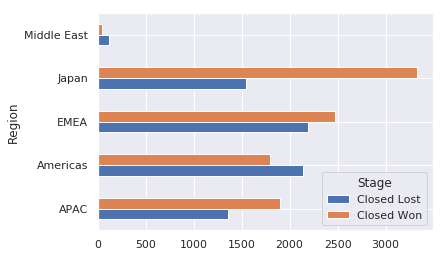

In [46]:
ct = pd.crosstab(data.Region, data.Stage)
ct.plot(kind="barh")

### 5.1 Comentarios finales

A modo de resumen, podemos separar en tres diferentes etapas el flujo temporal de nuestra solución. En un primer momento, realizamos una evaluación de las características del conjunto de datos junto con un análisis exploratorio preliminar. En este período reunimos evidencia a favor de la utilización de **modelos basados en árboles de decisión**. Las primeras submissions realizadas reflejaron que en el *leaderboard* público estos modelos alcanzaban una precisión razonable incluso con un preproceso no muy detallado de los datos de entrenamiento.

Durante la segunda etapa nos dedicamos a tratar de entender en mayor profundidad la lógica del proceso de negociación de las oportunidades. En esta segunda parte produjimos la mayor parte de las nuevas variables que describimos en las secciones previas. Reforzamos la idea de que el **aporte humano** es responsable de la diferencia entre una predicción razonable y una muy buena, incluso aplicando el mismo modelo de predicción. De haber sido posible, en esta etapa hubiéramos aprovechado el feedback del cliente para generar un mayor entendimiento del proceso de negociación. Por ejemplo: ¿qué se puede decir sobre la estacionalidad del producto (hay fluctuaciones que se observan agrupando por la variable *Delivery_Quarter*)? ¿Qué sabe el cliente sobre las diferencias de las negociaciones en diferentes territorios? ¿Qué significan los códigos burocráticos? ¿Qué significan los datos faltantes en algunas columnas (como en *ASP*)?
Incluso con estas limitaciones, las herramientas desarrolladas durante esta etapa nos situaron cerca de los primeros puestos en el *leaderboard* público.

Finalmente, dedicamos los últimos días de la competencia al ajuste fino de los hiperparámetros y a la experimentación de diversas maneras de combinar las predicciones de modelos de mejor rendimiento. Esta última parte nos dio el empujón final y nos llevó a colocarnos entre los primeros diez lugares del *leaderboard* público.

In [6]:
clear = ["Opportunity_Name","ID","Last_Activity", "Brand", "Product_Type", 
          "Prod_Category_A", "Product_Category_B", "ASP_(converted)_Currency", "Product_Name", 
         "Delivery_Year", "TRF", "Submitted_for_Approval", "Delivery_Terms", "Size",
         "Price", "ASP_Currency", "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type",
         "Product_Family", "Account_Name"]
dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date", "Last_Activity", "Actual_Delivery_Date"]
target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [51]:
data.drop(clear + target + dates, axis = 1).columns

Index([u'Region', u'Territory', u'Pricing, Delivery_Terms_Quote_Appr',
       u'Pricing, Delivery_Terms_Approved', u'Bureaucratic_Code_0_Approval',
       u'Bureaucratic_Code_0_Approved', u'Bureaucratic_Code', u'Source ',
       u'Billing_Country', u'Account_Owner', u'Opportunity_Owner',
       u'Account_Type', u'Currency', u'Last_Modified_By', u'ASP',
       u'ASP_(converted)', u'Month', u'Delivery_Quarter', u'Total_Amount',
       u'Total_Taxable_Amount', u'Contract_Defined', u'Contacts',
       u'Delivery_Gap', u'Offer_Period', u'Concrete_Offer', u'Sales'],
      dtype='object')

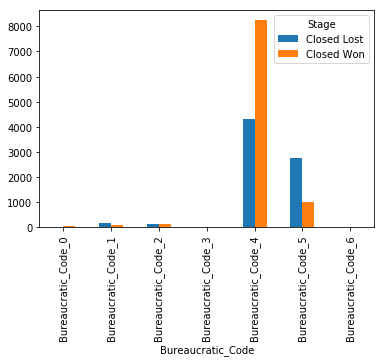

In [55]:
pd.crosstab(data.Bureaucratic_Code, data.Stage).plot(kind='bar')

In [12]:
data.groupby("Stage")["TRF"].mean()

Stage
Closed Lost    4.954150
Closed Won     0.317109
Name: TRF, dtype: float64

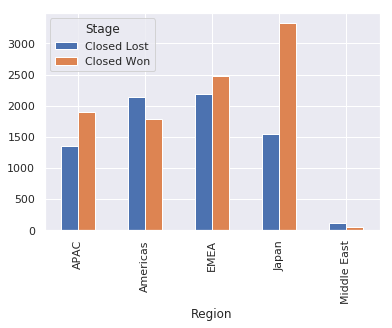

In [14]:
pd.crosstab(data.Region, data.Stage).plot(kind="bar")

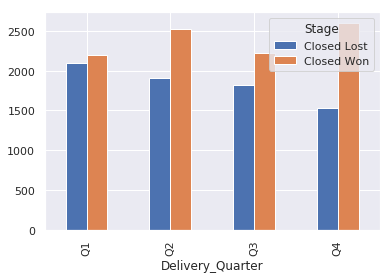

In [15]:
pd.crosstab(data.Delivery_Quarter, data.Stage).plot(kind="bar")